In [2397]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import stats

Read Gold (D1) data:

In [2398]:
dfG=pd.read_csv('quotes/XAUUSD.csv') 
dfG.columns=['date','time','open','high','low','close','volume'] 
dfG=dfG[['date','open','close','low','high']]
dfG.set_index('date',inplace=True)
dfG=dfG.drop(['high','low','open'], axis=1) 
dfG.rename(columns={'close':'closeG'},inplace=True)
dfG.index=pd.to_datetime(dfG.index)

Read Silver (D1) data:

In [2399]:
dfS=pd.read_csv('quotes/XAGUSD.csv') 
dfS.columns=['date','time','open','high','low','close','volume'] 
dfS=dfS[['date','open','close','low','high']]
dfS.set_index('date',inplace=True)
dfS=dfS.drop(['high','low','open'], axis=1) 
dfS.rename(columns={'open':'openS','close':'closeS'},inplace=True)
dfS.index=pd.to_datetime(dfS.index)

Merging of 2 frames by indexes:

In [2400]:
df=pd.merge(dfS,dfG,how='inner',left_index=True,right_index=True)
df=df.dropna()
print('Dataframe information:\n')
print(df.info())

Dataframe information:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2048 entries, 2011-09-28 to 2019-08-30
Data columns (total 2 columns):
closeS    2048 non-null float64
closeG    2048 non-null float64
dtypes: float64(2)
memory usage: 48.0 KB
None


Convert prices to returns by log function and taking differences:

In [2401]:
df=df[['closeS','closeG']].apply(np.log)
df=df.diff(axis=0,periods=1)
df=df.dropna()
df.rename(columns={'closeS':'RetS','closeG':'RetG'},inplace=True)
df.describe()

,RetS,RetG
count,2047.000000,2047.000000
mean,-0.000238,-0.000026
std,0.015010,0.009312
min,-0.142630,-0.095693
25%,-0.007517,-0.004821
50%,0.000051,0.000167
75%,0.006982,0.004714
max,0.070627,0.047798


Normalize returns in order to make stable regression and factor analysis:

In [2402]:
df=(df-df.min())/(df.max()-df.min()) 
df=df.dropna()
print('\nNulls number:')
print(df.isnull().sum())


Nulls number:
RetS    0
RetG    0
dtype: int64


Max/min are slowly changing parameters which have to be updated on the regular basis:

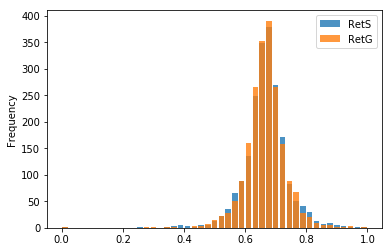

In [2403]:
df[['RetS','RetG']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8)
plt.show()

In [2404]:
df.describe()

,RetS,RetG
count,2047.000000,2047.000000
mean,0.667702,0.666712
std,0.070385,0.064896
min,0.000000,0.000000
25%,0.633569,0.633293
50%,0.669060,0.668057
75%,0.701560,0.699742
max,1.000000,1.000000


Relative volatility is comparable. The arbitrage model can be stable enough. Look at the outliers:

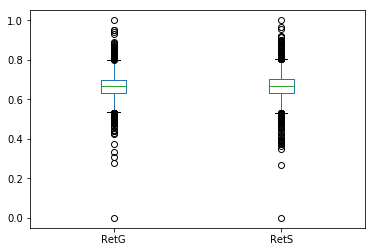

In [2405]:
df[['RetG','RetS']].boxplot(grid=False) 
plt.show()

Ouliers are not "bad". Actually they represent inefficiencies which are required (!) for a good investment opportunity. Let's look at Pearson correlation and significance of H0 hypothesis:

In [2406]:
pc=sc.stats.pearsonr(list(df['RetG']),list(df['RetS']))
print('Gold vs Silver return correlation (Pearson):',round(pc[0],2))
print('Gold vs Silver return 2-tailed p-value:',round(pc[1],2))

Gold vs Silver return correlation (Pearson): 0.82
Gold vs Silver return 2-tailed p-value: 0.0


Correlation is good enough for arbitrage opportunities. Create scatter plot of Gold vs Silver. Look at the relative return:

In [2407]:
df['Relative return']=df['RetG']/df['RetS']
df=df.dropna()
description=df['Relative return'].describe()

print('\nNulls number:')
print(df.isnull().sum())

print('\nStatistical description:')
print(description)

mean=description[1]
std=description[2]

u1=round(mean+1*std,2)
u2=round(mean+3*std,2)

l1=round(mean-1*std,2)
l2=round(mean-3*std,2)


Nulls number:
RetS               0
RetG               0
Relative return    0
dtype: int64

Statistical description:
count    2046.000000
mean        1.001405
std         0.063725
min         0.725368
25%         0.965935
50%         0.999808
75%         1.032229
max         1.418389
Name: Relative return, dtype: float64


Create visual representation. Two ranges of 1 sigma and 3 sigma are added. Recent point is marked by 'bold':

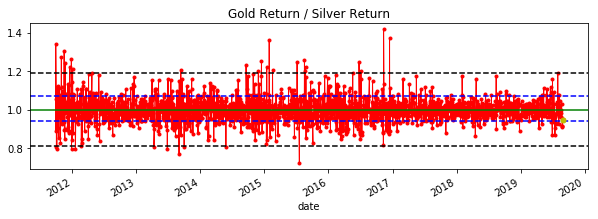

In [2408]:
plt.figure(figsize=(10,3))
df['Relative return'].plot(color='r',marker='o',linewidth=1, markersize=3)

plt.axhline(y=mean,color='g',linestyle='-')

plt.axhline(y=u1,color='b',linestyle='--')
plt.axhline(y=l1,color='b',linestyle='--')
plt.axhline(y=u2,color='black',linestyle='--')
plt.axhline(y=l2,color='black',linestyle='--')
plt.plot(df['Relative return'].index[-1], df['Relative return'].values[-1],'oy',markersize=5)

plt.title('Gold Return / Silver Return')
plt.show()

Median (50%) is close to the average value.

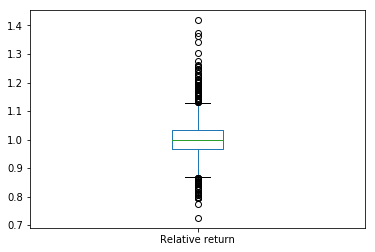

In [2409]:
df['Relative return'].plot.box(grid=False) 
plt.show()

There are more arbitrage opportunities in the "overbought" region. Actually this means panic purchase of gold as the hedge asset. Relative return seems to be mean reverting to the parity. Now we check the relative return for stationarity by ADF test: 

In [2410]:
z=df['Relative return'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -47.647861
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


We can reject the null hypothesis of time series stationarity. Strongly negative ADF statistic. Probability distribution of relative return proves that we can rely on the attraction zone:

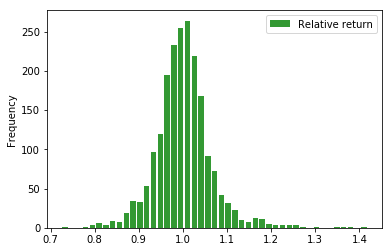

In [2411]:
df[['Relative return']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,color='g',alpha=0.8)
plt.show()

We may define the average mean reversion time in the frame of ARIMA. First rescale the reverting series by substracting the average. Define differences of relative returns (price acceleration) and shift first time series:

In [2412]:
df.drop(['RetS','RetG'],axis=1,inplace=True) 
df['Relative return']=df['Relative return']-df['Relative return'].mean()
df['Difference']=df['Relative return'].diff() 
df['Relative return']=df['Relative return'].shift(1,axis = 0)
df=df.dropna()

Make scatter plot:

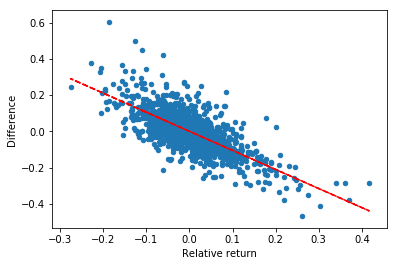

In [2413]:
df.plot.scatter(x='Relative return',y='Difference') 

a=list(df['Relative return'])
b=list(df['Difference'])

z=np.polyfit(a,b,1)
p=np.poly1d(z)

plt.plot(a,p(a),"r--")
plt.show()

Show Person correlation and significance of H0 hypothesis: 

In [2414]:
pc=sc.stats.pearsonr(list(df['Relative return']),list(df['Difference']))
print('Gold vs Silver return correlation (Pearson):',round(pc[0],2))
print('Gold vs Silver return 2-tailed p-value:',round(pc[1],2))

Gold vs Silver return correlation (Pearson): -0.73
Gold vs Silver return 2-tailed p-value: 0.0


Calcultation of mean reversion decay time. It is the recommended time of long-short position hold:

In [2415]:
print('Mean reversion time:',int(round(-math.log(2)/list(z)[0])),'day')

Mean reversion time: 1 day
